# Part 0: Miscellaneous

## Import packages

In [1]:
!pip install surprise

In [2]:
import pandas as pd
import zipfile
import seaborn as sns
import numpy as np
from collections import defaultdict
from scipy import optimize
from surprise import SVD, Reader, Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection.search import GridSearchCV

## Coding convention

1. Use dataframes as much as possible.
2. Set random seed in all cells with random operation.

In [3]:
RANDOM_SEED = 258258

# Part 1: Identify a dataset to study


## Raw dataset

We use the food.com recipe and review dataset. We get the dataset from [here](https://cseweb.ucsd.edu/~jmcauley/datasets.html#foodcom)

Note: we will use the raw data instead of the provided pre-processed data and do the data cleanup ourselves.

Citation:

Generating Personalized Recipes from Historical User Preferences

Bodhisattwa Prasad Majumder*, Shuyang Li*, Jianmo Ni, Julian McAuley

EMNLP, 2019

Get the PDF [here](https://cseweb.ucsd.edu/~jmcauley/pdfs/emnlp19c.pdf)

In [4]:
interactions_zipfile = zipfile.ZipFile('RAW_interactions.csv.zip')
interactions_raw = pd.read_csv(interactions_zipfile.open('RAW_interactions.csv'))

In [5]:
recipes_zipfile = zipfile.ZipFile('RAW_recipes.csv.zip')
recipes_raw = pd.read_csv(recipes_zipfile.open('RAW_recipes.csv'))

In [6]:
interactions_raw

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...


In [7]:
recipes_raw

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8
...,...,...,...,...,...,...,...,...,...,...,...,...
231632,zydeco soup,486161,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"['celery', 'onion', 'green sweet pepper', 'gar...",22
231633,zydeco spice mix,493372,5,1500678,2013-01-09,"['15-minutes-or-less', 'time-to-make', 'course...","[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,['mix all ingredients together thoroughly'],this spice mix will make your taste buds dance!,"['paprika', 'salt', 'garlic powder', 'onion po...",13
231634,zydeco ya ya deviled eggs,308080,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', 'mayonnaise', 'dijon must...",8
231635,cookies by design cookies on a stick,298512,29,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...","['butter', 'eagle brand condensed milk', 'ligh...",10


## Preprocessing

Separate nutritional value into different columns

In [8]:
recipes_raw['nutrition_calories'] = recipes_raw['nutrition'].apply(lambda x: eval(x)[0])
recipes_raw['nutrition_total_fat'] = recipes_raw['nutrition'].apply(lambda x: eval(x)[1])
recipes_raw['nutrition_sugar'] = recipes_raw['nutrition'].apply(lambda x: eval(x)[2])
recipes_raw['nutrition_sodium'] = recipes_raw['nutrition'].apply(lambda x: eval(x)[3])
recipes_raw['nutrition_protein'] = recipes_raw['nutrition'].apply(lambda x: eval(x)[4])
recipes_raw['nutrition_saturated_fat'] = recipes_raw['nutrition'].apply(lambda x: eval(x)[5])
recipes_raw['nutrition_carbohydrates'] = recipes_raw['nutrition'].apply(lambda x: eval(x)[6])

Convert date

In [9]:
recipes_raw['submitted'] = pd.to_datetime(recipes_raw.submitted)
interactions_raw['date'] = pd.to_datetime(interactions_raw.date)
interactions_raw['date_year'] = interactions_raw['date'].apply(lambda x: x.year)
interactions_raw['date_month'] = interactions_raw['date'].apply(lambda x: x.month)


## Exploratory analysis on raw data + Cleanup along the way

### Recipes

In [10]:
recipes_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   name                     231636 non-null  object        
 1   id                       231637 non-null  int64         
 2   minutes                  231637 non-null  int64         
 3   contributor_id           231637 non-null  int64         
 4   submitted                231637 non-null  datetime64[ns]
 5   tags                     231637 non-null  object        
 6   nutrition                231637 non-null  object        
 7   n_steps                  231637 non-null  int64         
 8   steps                    231637 non-null  object        
 9   description              226658 non-null  object        
 10  ingredients              231637 non-null  object        
 11  n_ingredients            231637 non-null  int64         
 12  nutrition_calori

In [11]:
recipes_raw.describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99])

,id,minutes,contributor_id,n_steps,n_ingredients,nutrition_calories,nutrition_total_fat,nutrition_sugar,nutrition_sodium,nutrition_protein,nutrition_saturated_fat,nutrition_carbohydrates
count,231637.000000,2.316370e+05,2.316370e+05,231637.000000,231637.000000,231637.000000,231637.00000,231637.000000,231637.000000,231637.00000,231637.000000,231637.000000
mean,222014.708984,9.398546e+03,5.534885e+06,9.765499,9.051153,473.942425,36.08070,84.296865,30.147485,34.68186,45.589150,15.560403
std,141206.635626,4.461963e+06,9.979141e+07,5.995128,3.734796,1189.711374,77.79884,800.080897,131.961589,58.47248,98.235758,81.824560
min,38.000000,0.000000e+00,2.700000e+01,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
1%,6949.720000,2.000000e+00,1.543000e+03,1.000000,3.000000,18.400000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
10%,41593.600000,1.000000e+01,2.599080e+04,4.000000,5.000000,93.100000,2.00000,3.000000,1.000000,2.00000,1.000000,1.000000
20%,80857.600000,1.800000e+01,4.265100e+04,5.000000,6.000000,148.600000,6.00000,7.000000,3.000000,5.00000,5.000000,3.000000
30%,119127.200000,2.500000e+01,6.832000e+04,6.000000,7.000000,200.400000,10.00000,12.000000,6.000000,8.00000,9.000000,5.000000
40%,162128.800000,3.000000e+01,1.151780e+05,7.000000,8.000000,254.800000,15.00000,17.000000,10.000000,12.00000,15.000000,7.000000
50%,207249.000000,4.000000e+01,1.736140e+05,9.000000,9.000000,313.400000,20.00000,25.000000,14.000000,18.00000,23.000000,9.000000


In [12]:
recipes = recipes_raw.copy()

#### Remove outliers

##### Minutes

Some kind of recipes (e.g. liquors) take some time to make. For example, (106563, 'homemade fruit liquers') takes 288000 minutes = 200 days to make.

[TOIMPROVE] We can scale the minutes based on the kind of the recipes.

Cleanup: the first entry is dirty and the second entry is a troll.

In [13]:
recipes_raw.nlargest(10, 'minutes')

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,nutrition_calories,nutrition_total_fat,nutrition_sugar,nutrition_sodium,nutrition_protein,nutrition_saturated_fat,nutrition_carbohydrates
144074,no bake granola balls,261647,2147483647,464080,2007-10-26,"['60-minutes-or-less', 'time-to-make', 'course...","[330.3, 23.0, 110.0, 4.0, 15.0, 24.0, 15.0]",9,"['preheat the oven to 350 degrees', 'spread oa...",healthy snacks that kids (and grown ups) will ...,"['rolled oats', 'unsweetened dried shredded co...",8,330.3,23.0,110.0,4.0,15.0,24.0,15.0
109624,how to preserve a husband,447963,1051200,576273,2011-02-01,"['time-to-make', 'course', 'preparation', 'for...","[407.4, 57.0, 50.0, 1.0, 7.0, 115.0, 5.0]",9,"['be careful in your selection', ""don't choose...","found this in a local wyoming cookbook ""a coll...","['cream', 'peach']",2,407.4,57.0,50.0,1.0,7.0,115.0,5.0
106563,homemade fruit liquers,291571,288000,553251,2008-03-12,"['time-to-make', 'course', 'main-ingredient', ...","[836.2, 0.0, 333.0, 0.0, 0.0, 0.0, 27.0]",12,"['rinse the fruit or berries , fruit must be c...",this should be a nice easy project for those w...,"['berries', 'vodka', 'granulated sugar']",3,836.2,0.0,333.0,0.0,0.0,0.0,27.0
38116,celtic druid s honey mead meade metheglin,216215,259260,242729,2007-03-11,"['time-to-make', 'course', 'main-ingredient', ...","[531.0, 0.0, 561.0, 1.0, 1.0, 0.0, 47.0]",18,"['equipement:', 'very large pan - to hold 12 p...","mead, made from fermented honey, was the earli...","['gingerroot', 'lemons, juice and rind of', 'w...",7,531.0,0.0,561.0,1.0,1.0,0.0,47.0
106963,homemade vanilla,425681,259205,28177,2010-05-16,"['time-to-make', 'preparation', '5-ingredients...","[69.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",9,['slice the vanilla beans length-wise and scra...,found this recipe on tammy's blog (http://www....,"['vanilla beans', 'vodka']",2,69.4,0.0,0.0,0.0,0.0,0.0,0.0
155044,peach brandy,98912,216015,34146,2004-09-01,"['time-to-make', 'course', 'main-ingredient', ...","[3645.3, 3.0, 2040.0, 0.0, 16.0, 0.0, 173.0]",9,"['use only fully ripened , unblemished fruit',...",posted in reply to a message board request for,"['fresh peaches', 'granulated sugar', 'honey',...",4,3645.3,3.0,2040.0,0.0,16.0,0.0,173.0
5497,angelica liqueur,70551,201610,59064,2003-09-04,"['weeknight', 'time-to-make', 'course', 'cuisi...","[891.8, 0.0, 906.0, 0.0, 1.0, 0.0, 76.0]",7,"['crush the fennel , aniseed , coriander seeds...",finish off a large meal with a tiny glass of t...,"['fennel seed', 'anise seed', 'coriander seeds...",7,891.8,0.0,906.0,0.0,1.0,0.0,76.0
177906,rumtopf,12931,187200,5060,2001-10-20,"['weeknight', 'time-to-make', 'course', 'main-...","[11510.6, 10.0, 6543.0, 2.0, 51.0, 5.0, 579.0]",16,"['in a 8 quart stockpot , combine sugar and wa...",rumtopf is a traditional german delicious frui...,"['sugar', 'water', 'golden rum', 'peaches', 'g...",8,11510.6,10.0,6543.0,2.0,51.0,5.0,579.0
170999,raspberry liqueur,172114,172810,83093,2006-06-09,"['time-to-make', 'course', 'main-ingredient', ...","[91.5, 0.0, 35.0, 0.0, 0.0, 0.0, 3.0]",7,['rinse the berries & cut into small pieces or...,if you love chambord as i do but suffer sticke...,"['fresh raspberry', 'vodka', 'fine sugar']",3,91.5,0.0,35.0,0.0,0.0,0.0,3.0
53721,cinnamon extract,153634,172800,208121,2006-01-30,"['time-to-make', 'course', 'preparation', 'for...","[14.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",5,"['put ingredients in container', 'combine', 'p...",a no brainer.. so why didn't i think of it? \r...,"['cinnamon sticks', 'vodka']",2,14.3,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
RECIPE_MAX_MINUTE_THRESHOLD = 288000
recipes = recipes[recipes['minutes'] <= RECIPE_MAX_MINUTE_THRESHOLD]

##### Contributor ID

There is some pattern in the contributor ID
1. Most of them have small contributor ID (e.g. 46273230)
2. A small group is 180XXXXXXX
3. Another small group is 200XXXXXXX

[TOIMPROVE] Not sure if this is a pattern that we can utilize.

In [15]:
print(recipes_raw[recipes_raw['contributor_id'] <= 1800000000]['contributor_id'].count())
print(recipes_raw[(recipes_raw['contributor_id'] > 1800000000) & (recipes_raw['contributor_id'] <= 2000000000)]['contributor_id'].count())
print(recipes_raw[recipes_raw['contributor_id'] > 2000000000]['contributor_id'].count())

231002
303
332


In [16]:
recipes_raw[recipes_raw['contributor_id'] <= 1800000000].nlargest(10, 'contributor_id')

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,nutrition_calories,nutrition_total_fat,nutrition_sugar,nutrition_sodium,nutrition_protein,nutrition_saturated_fat,nutrition_carbohydrates
88476,frozen peanut butter pie low carb,519541,5,46273230,2014-11-17,"['15-minutes-or-less', 'time-to-make', 'course...","[220.5, 32.0, 7.0, 5.0, 10.0, 45.0, 1.0]",6,['blend together cream cheese & peanut butter'...,simple fast dessert for the peanut butter fans...,"['cream cheese', 'crunchy peanut butter', 'hea...",4,220.5,32.0,7.0,5.0,10.0,45.0,1.0
126163,low carb raw coconut brownie balls,517553,75,46273230,2014-07-30,"['time-to-make', 'course', 'main-ingredient', ...","[199.7, 30.0, 5.0, 0.0, 6.0, 56.0, 1.0]",10,"['first , toast your coconut in a 350 degree o...",this recipe is my own creation. i had a raw b...,"['walnuts', 'unsweetened coconut', 'cocoa powd...",7,199.7,30.0,5.0,0.0,6.0,56.0,1.0
192526,southern red beans rice for the pressure cooker,511454,65,46273230,2013-12-30,"['weeknight', 'time-to-make', 'course', 'main-...","[259.4, 8.0, 12.0, 25.0, 27.0, 4.0, 13.0]",13,"['in your pressure cooker without the lid , he...",this is an adaptation of a new orleans style r...,"['olive oil', 'onions', 'bell pepper', 'celery...",14,259.4,8.0,12.0,25.0,27.0,4.0,13.0
206855,sweet spiced nuts sugar free,519587,50,46273230,2014-11-20,"['60-minutes-or-less', 'time-to-make', 'course...","[204.8, 32.0, 4.0, 6.0, 7.0, 11.0, 1.0]",9,"['preheat oven to 250 degrees', 'spray a sheet...",i found a fabulous sweet spicy nut recipe here...,"['egg white', 'walnuts', 'macadamia nuts', 'pe...",10,204.8,32.0,4.0,6.0,7.0,11.0,1.0
231176,zucchini fritters low carb,522243,25,46273230,2015-06-01,"['30-minutes-or-less', 'time-to-make', 'course...","[140.3, 18.0, 7.0, 17.0, 10.0, 24.0, 1.0]",16,"['shred or grate zucchini', 'using fine sieve ...",this is an excellent side dish for summer meal...,"['zucchini', 'scallions', 'eggs', 'cream chees...",12,140.3,18.0,7.0,17.0,10.0,24.0,1.0
38866,cheddar cheese bacon wrapped chicken breast at...,509097,60,46236180,2013-11-07,"['weeknight', '60-minutes-or-less', 'time-to-m...","[293.4, 26.0, 3.0, 6.0, 62.0, 25.0, 0.0]",14,"['preheat oven to 350', 'add water to a baking...",always tender and juicy with loads of flavor t...,"['boneless chicken breasts', 'bacon', 'salt', ...",10,293.4,26.0,3.0,6.0,62.0,25.0,0.0
64047,creamy turkey soup with homemade noodles,520819,1620,45906291,2015-01-26,"['time-to-make', 'course', 'preparation', 'for...","[208.5, 18.0, 4.0, 26.0, 14.0, 35.0, 5.0]",22,"['noodle preparation: place 2 cups flour , pou...",a great soup to deliciously use up leftover tu...,"['all-purpose flour', 'egg', 'salt', 'poultry ...",21,208.5,18.0,4.0,26.0,14.0,35.0,5.0
115291,jk wasabi dip public,513264,80,43683172,2014-02-12,"['time-to-make', 'course', 'preparation', 'for...","[114.5, 7.0, 19.0, 54.0, 15.0, 8.0, 3.0]",14,"['1', 'place the eggs into a saucepan in a sin...",jk wasabi dip recipe description,"['eggs', 'onion', 'tomatoes', 'fresh lime juic...",10,114.5,7.0,19.0,54.0,15.0,8.0,3.0
159100,phena s asian chicken kabobs a1,518148,110,43602985,2014-08-25,"['time-to-make', 'main-ingredient', 'preparati...","[159.1, 5.0, 60.0, 51.0, 21.0, 3.0, 7.0]",14,['place chicken pieces in a gallon sized ziplo...,a.1. original sauce recipe contest entry: thes...,"['boneless skinless chicken thighs', 'green be...",13,159.1,5.0,60.0,51.0,21.0,3.0,7.0
159101,phena s baked turkey flautas a1,518182,55,43602985,2014-08-25,"['60-minutes-or-less', 'time-to-make', 'course...","[198.1, 12.0, 5.0, 12.0, 24.0, 16.0, 6.0]",15,"['preheat oven to 425 degrees', 'heat a large ...",a.1. original sauce contest entry: these are s...,"['ground turkey', 'dried onion flakes', 'mince...",14,198.1,12.0,5.0,12.0,24.0,16.0,6.0


In [17]:
recipes_raw[recipes_raw['contributor_id'] <= 2000000000].nlargest(10, 'contributor_id')

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,nutrition_calories,nutrition_total_fat,nutrition_sugar,nutrition_sodium,nutrition_protein,nutrition_saturated_fat,nutrition_carbohydrates
56166,coffe and ricola,528439,5,1803771397,2016-09-28,"['15-minutes-or-less', 'time-to-make', 'course...","[48.8, 0.0, 50.0, 0.0, 0.0, 0.0, 4.0]",3,"['brew one large cup of coffee', 'disolve the ...","i know this sounds odd, but give it a try. it...","['coffee', 'sugar']",2,48.8,0.0,50.0,0.0,0.0,0.0,4.0
23116,better than takeout chicken fried rice from ra...,521101,20,1803767857,2015-02-17,"['30-minutes-or-less', 'time-to-make', 'course...","[759.7, 23.0, 6.0, 47.0, 56.0, 14.0, 41.0]",6,['heat sesame oil in a large skillet on medium...,http://rachelschultz.com/2012/07/14/better-tha...,"['rice', 'boneless skinless chicken breast', '...",8,759.7,23.0,6.0,47.0,56.0,14.0,41.0
147975,one pan crispy chicken legs and brussels sprouts,520924,50,1803739581,2015-02-03,"['60-minutes-or-less', 'time-to-make', 'course...","[446.7, 52.0, 4.0, 7.0, 62.0, 63.0, 0.0]",20,"['preheat your oven to 425 degrees', 'wash , p...",cooked in a cast-iron skillet.,"['chicken legs', 'brussels sprout', 'coconut o...",9,446.7,52.0,4.0,7.0,62.0,63.0,0.0
70910,delicious gluten free carrot cake,520919,60,1803734864,2015-02-03,"['60-minutes-or-less', 'time-to-make', 'course...","[335.4, 16.0, 224.0, 13.0, 4.0, 25.0, 19.0]",12,"['cake:', 'preheat oven to 350 f', 'beat sugar...",this all time family favourite has just receiv...,"['cake', 'sugar', 'applesauce', 'gluten-free f...",17,335.4,16.0,224.0,13.0,4.0,25.0,19.0
144035,no bake chocolate fudge cake,520980,105,1803733845,2015-02-07,"['time-to-make', 'preparation', 'kid-friendly'...","[260.8, 27.0, 44.0, 6.0, 11.0, 39.0, 9.0]",7,"['heat butter in a non-stick pan , add chocola...",this fudge cake is not baked but set in the re...,"['dark chocolate', 'instant coffee powder', 'b...",7,260.8,27.0,44.0,6.0,11.0,39.0,9.0
1267,3 layer chocolate cake with chocolate mousse f...,520809,65,1803706112,2015-01-26,"['lactose', 'time-to-make', 'course', 'prepara...","[776.0, 74.0, 235.0, 26.0, 16.0, 144.0, 27.0]",37,"['start by making the cake:', 'preheat the ove...",this is a modification to gluten free chocolat...,"['sorghum flour', 'tapioca flour', 'rice flour...",19,776.0,74.0,235.0,26.0,16.0,144.0,27.0
47236,chicpea salad sandwiches,520739,20,1803692961,2015-01-23,"['30-minutes-or-less', 'time-to-make', 'prepar...","[259.3, 4.0, 20.0, 22.0, 24.0, 2.0, 15.0]",5,['smash the chickpeas to how thin you want the...,"""a new spin on the old-fashion chicken salad. ...","['chickpeas', 'celery', 'onions', 'mayonnaise'...",9,259.3,4.0,20.0,22.0,24.0,2.0,15.0
147758,one banana bread muffins,522925,30,1803673736,2015-07-29,"['60-minutes-or-less', '30-minutes-or-less', '...","[169.6, 9.0, 60.0, 6.0, 4.0, 17.0, 9.0]",12,"['preheat oven to 350', 'prep', 'muffin tin , ...","i had one ripe banana, and didn't want to toss...","['butter', 'banana', 'sugar', 'brown sugar', '...",10,169.6,9.0,60.0,6.0,4.0,17.0,9.0
3831,almond milk pancakes,526984,15,1803671534,2016-05-21,"['15-minutes-or-less', 'time-to-make', 'course...","[321.2, 20.0, 8.0, 32.0, 15.0, 7.0, 13.0]",7,"['whisk together flour , baking powder , sugar...",easy light pancakes! my husband loves pancake...,"['flour', 'baking powder', 'splenda sugar subs...",8,321.2,20.0,8.0,32.0,15.0,7.0,13.0
194825,spiced lentil chicken sausage soup,520488,150,1803636827,2015-01-09,"['time-to-make', 'course', 'preparation', 'mai...","[450.6, 25.0, 44.0, 61.0, 61.0, 24.0, 14.0]",8,"['brown sausage , onion , barley , and garlic ...",best winter soup recipe ever! i've been making...,"['italian sausage', 'diced onion', 'barley', '...",11,450.6,25.0,44.0,61.0,61.0,24.0,14.0


In [18]:
recipes_raw[recipes_raw['contributor_id'] > 2000000000].nlargest(10, 'contributor_id')


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,nutrition_calories,nutrition_total_fat,nutrition_sugar,nutrition_sodium,nutrition_protein,nutrition_saturated_fat,nutrition_carbohydrates
57639,copycat chick fil a spicy deluxe chicken sandwich,537331,80,2002289981,2018-10-25,"['time-to-make', 'course', 'main-ingredient', ...","[3630.9, 531.0, 56.0, 117.0, 66.0, 329.0, 36.0]",16,"['directions:', 'in a medium bowl whisk togeth...",if you love the spicy fried chicken this is yo...,"['pickle juice', 'whole milk', 'lemon juice', ...",21,3630.9,531.0,56.0,117.0,66.0,329.0,36.0
15158,baked shrimp and orzo with chickpeas lemon a...,537076,15,2002285039,2018-10-02,"['15-minutes-or-less', 'time-to-make', 'main-i...","[735.9, 39.0, 22.0, 71.0, 75.0, 40.0, 27.0]",18,"['preheat oven to 450 degrees', 'dry shrimp wi...",shrimp and orzo make for a simple and flavorfu...,"['jumbo shrimp', 'salt & freshly ground black ...",15,735.9,39.0,22.0,71.0,75.0,40.0,27.0
86309,french onion baked potato soup,537071,35,2002285039,2018-10-02,"['60-minutes-or-less', 'time-to-make', 'course...","[438.7, 41.0, 12.0, 19.0, 27.0, 65.0, 12.0]",17,"['place potatoes , broth , and 1 tablespoon sa...",meet the perfect mashup of two crowd-pleasing ...,"['yukon gold potatoes', 'low sodium chicken br...",13,438.7,41.0,12.0,19.0,27.0,65.0,12.0
111609,instant pot turkey chili,537073,80,2002285039,2018-10-02,"['time-to-make', 'course', 'main-ingredient', ...","[340.9, 29.0, 30.0, 7.0, 40.0, 17.0, 8.0]",16,"['preheat instant pot to saute setting', 'add ...",using dark meat turkey ensures a perfect chili.,"['olive oil', 'ground turkey', 'salt & freshly...",23,340.9,29.0,30.0,7.0,40.0,17.0,8.0
172553,red wine braised short ribs with fingerlings p...,537429,105,2002285039,2018-11-05,"['time-to-make', 'main-ingredient', 'preparati...","[333.2, 11.0, 25.0, 3.0, 10.0, 5.0, 15.0]",18,"['preheat instant pot to saute setting', 'dry ...",this will become an instant pot go-to.,"['ribs', 'salt & freshly ground black pepper',...",14,333.2,11.0,25.0,3.0,10.0,5.0,15.0
122058,lemon pom pom cake,536747,210,2002247884,2018-08-15,"['time-to-make', 'course', 'preparation', 'for...","[491.9, 37.0, 166.0, 8.0, 16.0, 68.0, 20.0]",51,"['for the vanilla cake:', 'preheat convection ...","by far one of my most joyous cake creations, t...","['cake flour', 'baking powder', 'flaked sea sa...",20,491.9,37.0,166.0,8.0,16.0,68.0,20.0
158729,peruvian breakfast sandwich,536603,75,2002234769,2018-07-30,"['time-to-make', 'cuisine', 'preparation', 'so...","[588.1, 84.0, 20.0, 41.0, 4.0, 35.0, 8.0]",5,['brine pork with salt pepper and a bit of cum...,"this is a sandwich inspired by ""pan con chicha...","['boneless ribs', 'salt', 'black pepper', 'yel...",13,588.1,84.0,20.0,41.0,4.0,35.0,8.0
12270,bacon and egg breakfast stromboli,536583,45,2002234364,2018-07-30,"['60-minutes-or-less', 'time-to-make', 'course...","[546.1, 67.0, 2.0, 25.0, 36.0, 75.0, 6.0]",18,['place oven rack in center of oven and prehea...,"delicious bacon, cheddar cheese and scrambled ...","['bacon', 'puff pastry', 'eggs', 'sharp chedda...",7,546.1,67.0,2.0,25.0,36.0,75.0,6.0
136734,miracle home made puff pastry,536610,35,2002234259,2018-07-31,"['60-minutes-or-less', 'time-to-make', 'course...","[2277.4, 264.0, 33.0, 79.0, 67.0, 512.0, 51.0]",17,['cut butter into very small cubes and place i...,puff pastry that you can make in minutes? at h...,"['all-purpose flour', 'salt', 'cream cheese', ...",6,2277.4,264.0,33.0,79.0,67.0,512.0,51.0
37720,cauliflower ceviche,536547,45,2002234079,2018-07-30,"['60-minutes-or-less', 'time-to-make', 'main-i...","[693.5, 47.0, 21.0, 31.0, 25.0, 18.0, 33.0]",15,['place cauliflower in a pot with one inch of ...,a healthy ceviche - a perfect appetizer for pa...,"['cauliflower', 'red onion', 'cilantro', 'cumi...",8,693.5,47.0,21.0,31.0,25.0,18.0,33.0


#### Nutrition

[TOIMPROVE] I think we should remove recipes that is too 'big' as indicated from the nutrition value. However, these recipes tend to be not serious anyway and will not be part of the prediction due to having less reviews.

In [19]:
recipes_raw.nlargest(10, 'nutrition_calories')

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,nutrition_calories,nutrition_total_fat,nutrition_sugar,nutrition_sodium,nutrition_protein,nutrition_saturated_fat,nutrition_carbohydrates
209453,tennessee moonshine,193435,20,374913,2006-11-01,"['30-minutes-or-less', 'time-to-make', 'course...","[434360.2, 1293.0, 362729.0, 1324.0, 3961.0, 5...",3,['to boiled cornmeal add yeast and lots of sug...,common moonshine recipe in tennessee,"['cornmeal', 'natural bran', 'sugar', 'yeast',...",5,434360.2,1293.0,362729.0,1324.0,3961.0,590.0,36098.0
70467,deep fried prime rib,227470,100,485396,2007-05-11,"['time-to-make', 'course', 'main-ingredient', ...","[101614.7, 17183.0, 0.0, 230.0, 1271.0, 10395....",12,['the night before you plan to serve your prim...,this makes the juicest and best flavored prime...,"['boneless rib-eye roast', 'peanut oil', 'grou...",6,101614.7,17183.0,0.0,230.0,1271.0,10395.0,1.0
165504,powdered hot cocoa mix,392286,10,180317,2009-09-28,"['15-minutes-or-less', 'time-to-make', 'course...","[45609.0, 3379.0, 16901.0, 1478.0, 4356.0, 687...",4,['mix all ingredients together in an airtight ...,our family grew up on this cocoa mix. we neve...,"['dry milk', 'nestles quik', 'powdered sugar',...",4,45609.0,3379.0,16901.0,1478.0,4356.0,6875.0,1453.0
137181,mmmmmmmmilky way cake,82848,60,4439,2004-02-02,"['60-minutes-or-less', 'time-to-make', 'course...","[44239.8, 2036.0, 17306.0, 2705.0, 936.0, 1441...",14,"['preheat oven to 350 degrees fahrenheit', 'gr...","this is not a true chocolate cake, but really ...","['yellow cake mix', 'butter', 'water', 'eggs',...",6,44239.8,2036.0,17306.0,2705.0,936.0,1441.0,2565.0
34023,caledonian wedding cake,18330,630,123897,2002-01-28,"['weeknight', 'time-to-make', 'course', 'main-...","[43924.6, 2556.0, 18943.0, 841.0, 1103.0, 4941...",3,"['bake 10 hours in a slow oven', 'one-quarter ...","found in old british cookbook, don't expect an...","['raisins', 'currants', 'figs', 'sweet almonds...",17,43924.6,2556.0,18943.0,841.0,1103.0,4941.0,2233.0
141997,my mercy strawberry cake,75591,60,30680,2003-11-05,"['60-minutes-or-less', 'time-to-make', 'course...","[42951.6, 2343.0, 1544.0, 2405.0, 886.0, 2155....",11,['strawberry cake directions: mix all together...,this cake came from my grandmother's best frie...,"['duncan hines butter cake mix', 'crisco cooki...",9,42951.6,2343.0,1544.0,2405.0,886.0,2155.0,2315.0
78689,easy easy friendship cake,48363,75,6258,2002-12-11,"['weeknight', 'time-to-make', 'course', 'main-...","[40159.2, 1922.0, 1024.0, 2386.0, 810.0, 1084....",7,['place all cake ingredients in a mixing bowl'...,it is simple and sweet. the original direction...,"['duncan hines butter cake mix', 'instant vani...",10,40159.2,1922.0,1024.0,2386.0,810.0,1084.0,2275.0
182816,scott hibb s amazing whiskey grilled baby back...,59776,180,52074,2003-04-15,"['time-to-make', 'course', 'main-ingredient', ...","[38680.1, 4317.0, 185.0, 686.0, 6540.0, 4960.0...",17,"['preheat oven to 300f', 'cut each full rack o...",this is really an amazing baby back ribs recip...,"['baby back rib racks', 'fresh coarse ground b...",18,38680.1,4317.0,185.0,686.0,6540.0,4960.0,18.0
199615,steph s pork riblets,93481,70,40135,2004-06-16,"['time-to-make', 'course', 'main-ingredient', ...","[38662.3, 4331.0, 77.0, 809.0, 6552.0, 4969.0,...",9,"['combine beef broth , soy sauce and brown sug...",i made this delicious recipe up last night. ki...,"['beef broth', 'soy sauce', 'brown sugar', 'po...",7,38662.3,4331.0,77.0,809.0,6552.0,4969.0,8.0
139058,moonshine easy,319406,7200,921886,2008-08-13,"['celebrity', 'time-to-make', 'preparation', '...","[36188.8, 106.0, 30260.0, 80.0, 329.0, 48.0, 3...",27,"['how to make moonshine at home', 'things need...",moonshine to make yourself,"['cornmeal', 'sugar', 'water', 'yeast']",4,36188.8,106.0,30260.0,80.0,329.0,48.0,3007.0


In [20]:
RECIPE_MAX_NUTRITION_CALORIES_THRESHOLD = 50000
recipes = recipes[recipes['nutrition_calories'] <= RECIPE_MAX_NUTRITION_CALORIES_THRESHOLD]

#### Basic statistics

In [21]:
recipes.describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99])

,id,minutes,contributor_id,n_steps,n_ingredients,nutrition_calories,nutrition_total_fat,nutrition_sugar,nutrition_sodium,nutrition_protein,nutrition_saturated_fat,nutrition_carbohydrates
count,231633.000000,231633.000000,2.316330e+05,231633.000000,231633.000000,231633.000000,231633.000000,231633.000000,231633.000000,231633.000000,231633.000000,231633.000000
mean,222013.662259,123.108689,5.534972e+06,9.765526,9.051219,471.633527,36.001213,82.731666,30.141275,34.659776,45.541913,15.404739
std,141207.037471,1977.776431,9.979227e+07,5.995161,3.734784,747.346403,69.113003,269.033244,131.934663,57.844032,95.847328,32.781275
min,38.000000,0.000000,2.700000e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,6949.640000,2.000000,1.543000e+03,1.000000,3.000000,18.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,41593.200000,10.000000,2.598560e+04,4.000000,5.000000,93.100000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000
20%,80856.400000,18.000000,4.265100e+04,5.000000,6.000000,148.600000,6.000000,7.000000,3.000000,5.000000,5.000000,3.000000
30%,119123.600000,25.000000,6.830840e+04,6.000000,7.000000,200.400000,10.000000,12.000000,6.000000,8.000000,9.000000,5.000000
40%,162125.800000,30.000000,1.151780e+05,7.000000,8.000000,254.800000,15.000000,17.000000,10.000000,12.000000,15.000000,7.000000
50%,207248.000000,40.000000,1.736140e+05,9.000000,9.000000,313.400000,20.000000,25.000000,14.000000,18.000000,23.000000,9.000000


#### Word clouds

In [22]:
# TODO

### Interactions

In [23]:
interactions_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   user_id     1132367 non-null  int64         
 1   recipe_id   1132367 non-null  int64         
 2   date        1132367 non-null  datetime64[ns]
 3   rating      1132367 non-null  int64         
 4   review      1132198 non-null  object        
 5   date_year   1132367 non-null  int64         
 6   date_month  1132367 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 60.5+ MB


In [24]:
interactions_raw.describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99])

,user_id,recipe_id,rating,date_year,date_month
count,1.132367e+06,1.132367e+06,1.132367e+06,1.132367e+06,1.132367e+06
mean,1.384291e+08,1.608972e+05,4.411016e+00,2.008874e+03,6.404559e+00
std,5.014269e+08,1.303987e+05,1.264752e+00,3.482943e+00,3.502333e+00
min,1.533000e+03,3.800000e+01,0.000000e+00,2.000000e+03,1.000000e+00
1%,6.651000e+03,3.595000e+03,0.000000e+00,2.002000e+03,1.000000e+00
10%,5.254300e+04,2.405400e+04,3.000000e+00,2.005000e+03,2.000000e+00
20%,1.071350e+05,4.302300e+04,4.000000e+00,2.006000e+03,3.000000e+00
30%,1.688960e+05,6.657500e+04,5.000000e+00,2.007000e+03,4.000000e+00
40%,2.284716e+05,9.204300e+04,5.000000e+00,2.008000e+03,5.000000e+00
50%,3.309370e+05,1.205470e+05,5.000000e+00,2.008000e+03,6.000000e+00


In [25]:
interactions_raw.groupby('rating').agg(count=('rating', 'size')).sort_values(by="rating", ascending=False)

,count
rating,
5,816364
4,187360
3,40855
2,14123
1,12818
0,60847


#### Ignore cold start

We are going to remove:
1. Recipes that does not have many reviews.
2. Reviews from users that does not have many reviews.

In [26]:
recipe_interactions_raw = interactions_raw.groupby('recipe_id').agg(count=('recipe_id', 'size'), mean=('rating', 'mean')).reset_index()
recipe_interactions_raw

,recipe_id,count,mean
0,38,4,4.250000
1,39,1,3.000000
2,40,9,4.333333
3,41,2,4.500000
4,43,1,1.000000
...,...,...,...
231632,537459,1,5.000000
231633,537485,1,5.000000
231634,537543,1,0.000000
231635,537671,1,0.000000


In [27]:
recipe_interactions_raw.sort_values(by="count", ascending=False).head(10)

,recipe_id,count,mean
833,2886,1613,4.185989
14424,27208,1601,4.288570
51312,89204,1579,4.220393
21639,39087,1448,4.541436
38631,67256,1322,4.329047
30638,54257,1305,4.213793
11695,22782,1234,4.423015
17473,32204,1220,4.525410
39713,69173,997,4.708124
39588,68955,904,4.398230


In [28]:
recipe_interactions_raw.loc[:, 'count'].describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.98,.99])

count    231637.000000
mean          4.888541
std          17.532481
min           1.000000
1%            1.000000
10%           1.000000
20%           1.000000
30%           1.000000
40%           2.000000
50%           2.000000
60%           3.000000
70%           3.000000
80%           5.000000
90%           9.000000
95%          15.000000
98%          29.000000
99%          47.000000
max        1613.000000
Name: count, dtype: float64

In [29]:
recipe_rating_count_threshold = 50 # We should remove recipe with less than 50 ratings
recipe_interactions_filtered = recipe_interactions_raw[recipe_interactions_raw['count'] >= recipe_rating_count_threshold]
recipe_interactions_filtered

,recipe_id,count,mean
112,246,65,4.615385
268,536,66,3.984848
310,607,147,4.074830
323,632,83,4.349398
374,749,190,4.378947
...,...,...,...
228824,505862,66,3.787879
229230,508302,51,3.000000
230055,514605,53,4.339623
230128,515167,74,4.932432


In [30]:
recipe_interactions_filtered.sort_values(by="mean", ascending=False).head(10)

,recipe_id,count,mean
31283,55309,52,5.000000
224586,486261,217,4.990783
23430,42038,57,4.964912
10652,21033,55,4.963636
135767,248495,53,4.962264
12132,23495,50,4.960000
36416,63621,74,4.959459
34003,59776,63,4.952381
224587,486267,51,4.941176
20638,37455,67,4.940299


In [31]:
user_interactions_raw = interactions_raw.groupby('user_id').agg(count=('user_id', 'size'), mean=('rating', 'mean')).reset_index()
user_interactions_raw

,user_id,count,mean
0,1533,128,4.710938
1,1535,794,4.473552
2,1581,1,5.000000
3,1634,60,3.616667
4,1676,31,4.677419
...,...,...,...
226565,2002371755,1,5.000000
226566,2002371792,1,4.000000
226567,2002371843,1,5.000000
226568,2002372464,1,4.000000


In [32]:
user_interactions_raw.sort_values(by="count", ascending=False).head(10)

,user_id,count,mean
46329,424680,7671,4.966888
3826,37449,5603,4.783866
43248,383346,4628,4.755186
20019,169430,4076,4.693327
15168,128473,3917,4.908348
10551,89831,3353,4.940352
6942,58104,3288,4.641727
15636,133174,3107,4.720953
23735,199848,3018,4.831014
35099,305531,2902,4.939697


In [33]:
user_interactions_raw.loc[:, 'count'].describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.98,.99])

count    226570.000000
mean          4.997868
std          49.663111
min           1.000000
1%            1.000000
10%           1.000000
20%           1.000000
30%           1.000000
40%           1.000000
50%           1.000000
60%           1.000000
70%           1.000000
80%           2.000000
90%           5.000000
95%          11.000000
98%          30.000000
99%          61.000000
max        7671.000000
Name: count, dtype: float64

In [34]:
user_rating_count_threshold = 50 # We should reviews from users with less than 50 reviews.
user_interactions_filtered = user_interactions_raw[user_interactions_raw['count'] >= user_rating_count_threshold]
user_interactions_filtered

,user_id,count,mean
0,1533,128,4.710938
1,1535,794,4.473552
3,1634,60,3.616667
26,2310,417,4.690647
27,2312,193,4.559585
...,...,...,...
181435,2000498330,310,4.422581
189635,2001047423,78,4.000000
190818,2001102678,135,4.948148
195519,2001297534,70,4.857143


In [35]:
user_interactions_filtered.sort_values(by="mean", ascending=False).head(10)

,user_id,count,mean
70026,745868,60,5.0
4210,39857,68,5.0
6470,55523,152,5.0
5603,50643,77,5.0
105974,1417292,95,5.0
87654,1052065,128,5.0
15219,128945,60,5.0
35762,312208,55,5.0
81673,934824,56,5.0
5408,49360,119,5.0


In [36]:
# Approach 0: do not remove any data
interactions = interactions_raw

In [37]:
# Approach 1 to make the dataset denser
interactions = interactions_raw.copy()
interactions = interactions.merge(recipe_interactions_filtered, on="recipe_id").merge(user_interactions_filtered, on="user_id")
interactions

,user_id,recipe_id,date,rating,review,date_year,date_month,count_x,mean_x,count_y,mean_y
0,6357,98783,2004-09-01,5,This was incredibly truly so yummy that my dad...,2004,9,68,4.500000,1455,4.526460
1,6357,32082,2004-10-09,5,I've made this cake and we enjoyed it! Very yu...,2004,10,75,4.600000,1455,4.526460
2,6357,16512,2002-02-10,5,OOOOOOOOOH! We all loved this! You were the HE...,2002,2,52,4.500000,1455,4.526460
3,6357,50124,2003-01-14,5,WOW! I really love these cinnamon oranges. It'...,2003,1,80,4.725000,1455,4.526460
4,6357,86353,2004-03-12,5,I had these for breakfast this morning drizzle...,2004,3,99,4.484848,1455,4.526460
...,...,...,...,...,...,...,...,...,...,...,...
95514,268973,17251,2006-08-20,5,This chicken had such a delicious flavor to it...,2006,8,89,4.764045,93,4.827957
95515,1269180,102843,2011-07-25,5,These were a winner for us - hubby got up and ...,2011,7,59,4.762712,117,4.538462
95516,545717,8554,2009-10-28,5,A perfect dinner for this cool fall weather. W...,2009,10,94,4.148936,76,4.657895
95517,282673,15875,2008-03-14,4,this was a nice tasty soup for a chilly day! i...,2008,3,56,4.357143,64,4.453125


In [38]:
# Approach 2: Iterative

def prune_by_recipe(interactions, threshold):
    recipe_interactions = interactions.groupby('recipe_id').agg(count=('recipe_id', 'size'), mean=('rating', 'mean')).reset_index()
    recipe_interactions_filtered = recipe_interactions[recipe_interactions['count'] >= threshold]
    pruned_interactions = interactions.merge(recipe_interactions_filtered, on="recipe_id")
    pruned_interactions = pruned_interactions.drop(columns=["count", "mean"])
    return pruned_interactions

def prune_by_user(interactions, threshold):
    user_interactions = interactions.groupby('user_id').agg(count=('user_id', 'size'), mean=('rating', 'mean')).reset_index()
    user_interactions_filtered = user_interactions[user_interactions['count'] >= threshold]
    pruned_interactions = interactions.merge(user_interactions_filtered, on="user_id")
    pruned_interactions = pruned_interactions.drop(columns=["count", "mean"])
    return pruned_interactions

def prune_iterative(interactions, recipe_threshold, user_threshold):
    pruned_interactions = interactions.copy()
    current_length = len(pruned_interactions)
    while True:
        pruned_interactions = prune_by_recipe(pruned_interactions, recipe_threshold)
        pruned_interactions = prune_by_user(pruned_interactions, user_threshold)
        print(f"Length: {len(pruned_interactions)}")
        if len(pruned_interactions) == current_length:
            break
        else:
            current_length = len(pruned_interactions)
    return pruned_interactions

interactions = prune_iterative(interactions_raw, 20, 15)
interactions

Length: 214506
Length: 149248
Length: 140032
Length: 138507
Length: 138277
Length: 138159
Length: 138126
Length: 138126


,user_id,recipe_id,date,rating,review,date_year,date_month
0,56680,152116,2006-03-07,5,"OK, I made this recipe because I went to make ...",2006,3
1,56680,97606,2013-07-07,4,"Very good, came together nice, needs more salt...",2013,7
2,56680,99156,2006-08-18,5,I made this recipe for dinner guests I had fro...,2006,8
3,56680,13949,2008-02-14,5,"Loved this,of course it fell apart, its cube s...",2008,2
4,56680,73450,2005-09-04,5,Absolutely wonderful tho DH used all the sausa...,2005,9
...,...,...,...,...,...,...,...
138121,388044,105594,2009-02-25,5,I think these have to be the best cupcakes Ive...,2009,2
138122,388044,127269,2007-09-06,5,These were really yummy! Easy to make too. The...,2007,9
138123,388044,25219,2007-11-09,5,This was the first time Ive made a frittata an...,2007,11
138124,388044,33921,2007-08-25,5,"I LOVE this ""meat""loaf! Its so easy to make, h...",2007,8


In [39]:
interactions.groupby('recipe_id').agg(count=('recipe_id', 'size'), mean=('rating', 'mean')).reset_index().sort_values(by="mean", ascending=False).head(10)

,recipe_id,count,mean
3161,334528,21,5.0
79,8507,30,5.0
1352,61816,41,5.0
2712,169500,34,5.0
3024,246875,24,5.0
1928,95365,21,5.0
2705,168529,29,5.0
2693,166669,28,5.0
1960,97213,20,5.0
2408,131054,20,5.0


In [40]:
interactions.groupby('user_id').agg(count=('user_id', 'size'), mean=('rating', 'mean')).reset_index().sort_values(by="mean", ascending=False).head(10)

,user_id,count,mean
1956,349172,16,5.0
2601,591894,18,5.0
1546,243474,25,5.0
674,97895,20,5.0
341,52026,19,5.0
879,130395,17,5.0
1908,336123,16,5.0
1342,209983,80,5.0
170,33376,15,5.0
1659,276833,19,5.0


In [41]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138126 entries, 0 to 138125
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     138126 non-null  int64         
 1   recipe_id   138126 non-null  int64         
 2   date        138126 non-null  datetime64[ns]
 3   rating      138126 non-null  int64         
 4   review      138125 non-null  object        
 5   date_year   138126 non-null  int64         
 6   date_month  138126 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 8.4+ MB


In [42]:
interactions.describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99])

,user_id,recipe_id,rating,date_year,date_month
count,1.381260e+05,138126.000000,138126.000000,138126.000000,138126.000000
mean,7.524027e+06,84606.434864,4.651231,2007.937535,6.360555
std,1.168975e+08,70272.327627,0.867039,2.785086,3.547859
min,1.535000e+03,246.000000,0.000000,2001.000000,1.000000
1%,7.108000e+03,3441.000000,0.000000,2002.000000,1.000000
10%,4.236700e+04,17764.000000,4.000000,2004.000000,1.000000
20%,7.346900e+04,28148.000000,4.000000,2006.000000,3.000000
30%,1.264350e+05,37465.000000,5.000000,2007.000000,4.000000
40%,1.699690e+05,52253.000000,5.000000,2007.000000,5.000000
50%,2.195255e+05,67256.000000,5.000000,2008.000000,6.000000


In [43]:
interactions_raw.groupby('rating').agg(count=('rating', 'size')).sort_values(by="rating", ascending=False)

,count
rating,
5,816364
4,187360
3,40855
2,14123
1,12818
0,60847


In [44]:
interactions.groupby('rating').agg(count=('rating', 'size')).sort_values(by="rating", ascending=False)

,count
rating,
5,108466
4,20857
3,4590
2,1224
1,480
0,2509


In [45]:
print(len(interactions.groupby('recipe_id')))
print(len(interactions.groupby('user_id')))

3217
3275


#### Review date

<Axes: >

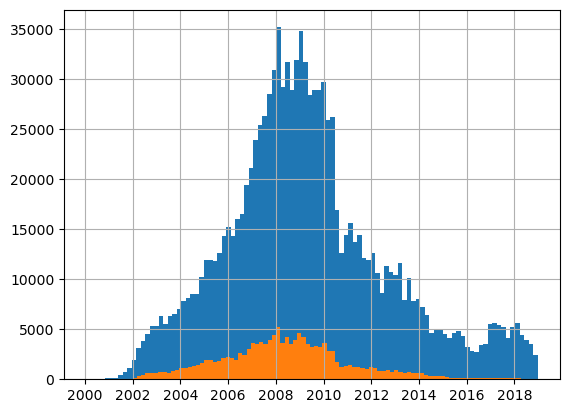

In [46]:
interactions_raw.loc[:, 'date'].hist(bins=100)
interactions.loc[:, 'date'].hist(bins=100)

Temporal pattern:

1. Year
2. Month
3. Year-Month ?
4. [TOIMPROVE] = Seasonal events (e.g. Thanksgiving, Christmas)

In [47]:
interactions_by_year = interactions.groupby('date_year').agg(count=('date_year', 'size'), mean=('rating', 'mean')).reset_index()
interactions_by_year

,date_year,count,mean
0,2001,84,4.630952
1,2002,2580,4.770543
2,2003,4377,4.777016
3,2004,7453,4.742251
4,2005,10932,4.764636
5,2006,13903,4.731856
6,2007,21510,4.632636
7,2008,23547,4.643394
8,2009,20404,4.668741
9,2010,12497,4.566296


In [48]:
interactions_by_month = interactions.groupby('date_month').agg(count=('date_month', 'size'), mean=('rating', 'mean')).reset_index()
interactions_by_month

,date_month,count,mean
0,1,14529,4.641820
1,2,11781,4.629149
2,3,11871,4.634235
3,4,10859,4.672714
4,5,10680,4.678558
5,6,11888,4.692799
6,7,10720,4.670709
7,8,10401,4.648111
8,9,10571,4.635134
9,10,11701,4.637809


#### Word clouds

In [49]:
# TODO

### Insights

#### Recipes that are created by top contributors tend to be better?

In [50]:
contributors = recipes.groupby('contributor_id').agg(count=('contributor_id', 'size')).sort_values(by="count", ascending=False).rename(columns={
    "count": "contributor_count",
})
contributors

,contributor_count
contributor_id,
89831,3118
37779,2553
37449,2493
1533,1595
58104,1522
...,...
344167,1
344188,1
344214,1


In [51]:
recipes_with_contributors = recipes.merge(contributors, on="contributor_id")
recipes_with_contributors

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,nutrition_calories,nutrition_total_fat,nutrition_sugar,nutrition_sodium,nutrition_protein,nutrition_saturated_fat,nutrition_carbohydrates,contributor_count
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,51.5,0.0,13.0,0.0,2.0,0.0,4.0,735
1,cream of pumpkin or squash soup vegan,164526,30,47892,2006-04-16,"['30-minutes-or-less', 'time-to-make', 'course...","[89.3, 0.0, 35.0, 0.0, 4.0, 0.0, 7.0]",9,"['place all ingredients except for banana , ap...",the creaminess comes from cashew butter (and b...,"['pumpkin puree', 'vegetable broth', 'small re...",14,89.3,0.0,35.0,0.0,4.0,0.0,7.0,735
2,navajo style peach crisp vegan friendly,484992,60,47892,2012-08-07,"['60-minutes-or-less', 'time-to-make', 'course...","[416.5, 27.0, 147.0, 10.0, 10.0, 39.0, 20.0]",11,"['preheat oven to 375 ?', 'butter or oil an 11...","from hell's backbone grill in boulder, utah (p...","['fresh peaches', 'natural cane sugar', 'unble...",8,416.5,27.0,147.0,10.0,10.0,39.0,20.0,735
3,tis an irish lamb stew,160398,120,47892,2006-03-17,"['time-to-make', 'course', 'main-ingredient', ...","[745.5, 66.0, 26.0, 7.0, 77.0, 92.0, 13.0]",13,"['preheat oven to 325f', 'in a large bowl gent...",traditional? haven't a clue. delicious? yes.\r...,"['boneless lamb shoulder', 'flour', 'baby pota...",15,745.5,66.0,26.0,7.0,77.0,92.0,13.0,735
4,tasty s hidden mickey surprise snack,362654,1,47892,2009-03-24,"['celebrity', '15-minutes-or-less', 'time-to-m...","[23.8, 0.0, 11.0, 0.0, 2.0, 0.0, 1.0]",6,['slice into a bell pepper crosswise and see i...,mommy discovered this little trick last year: ...,"['bell pepper', 'ranch dressing', 'salt and pe...",5,23.8,0.0,11.0,0.0,2.0,0.0,1.0,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231628,zucchini blueberry muffins,183345,45,277129,2006-08-27,"['60-minutes-or-less', 'time-to-make', 'course...","[103.5, 1.0, 37.0, 7.0, 5.0, 0.0, 7.0]",9,['preheat oven to 325 degrees f and grease a m...,moist and extremely healthy muffins!,"['zucchini', 'applesauce', 'old fashioned oats...",15,103.5,1.0,37.0,7.0,5.0,0.0,7.0,1
231629,zucchini onion salad,66897,18,92725,2003-07-16,"['30-minutes-or-less', 'time-to-make', 'course...","[231.1, 28.0, 27.0, 8.0, 8.0, 56.0, 5.0]",10,"['grate zucchini', 'dice onion', 'over medium ...","i wrinkled my nose at this in the beginning, t...","['onion', 'sour cream', 'butter', 'fresh groun...",7,231.1,28.0,27.0,8.0,8.0,56.0,5.0,1
231630,zuke muffins,386947,30,396497,2009-08-24,"['30-minutes-or-less', 'time-to-make', 'course...","[127.1, 3.0, 49.0, 7.0, 7.0, 2.0, 7.0]",16,"['1', ') preheat oven to 350', 'spray / line m...",delisious and healthy muffins,"['eggs', 'fat free greek yogurt', 'sugar', 'br...",11,127.1,3.0,49.0,7.0,7.0,2.0,7.0,1
231631,zuvers barbecue sauce,381216,30,763977,2009-07-13,"['30-minutes-or-less', 'time-to-make', 'course...","[595.5, 1.0, 527.0, 62.0, 5.0, 0.0, 50.0]",6,"['mix first 5 ingredients in sauce pan', 'turn...","this barbecue sauce is great on ribs, chicken ...","['molasses', 'ketchup', 'apple cider vinegar',...",12,595.5,1.0,527.0,62.0,5.0,0.0,50.0,1


In [52]:
_average_recipe_ratings = interactions.groupby('recipe_id').agg(mean=('rating', 'mean')).sort_values(by="mean", ascending=False).rename(columns={
    "mean": "average_rating",
})
# Run this once!
average_recipe_ratings_with_contributors = _average_recipe_ratings.merge(recipes_with_contributors, left_on="recipe_id", right_on="id")

<Axes: xlabel='contributor_count'>

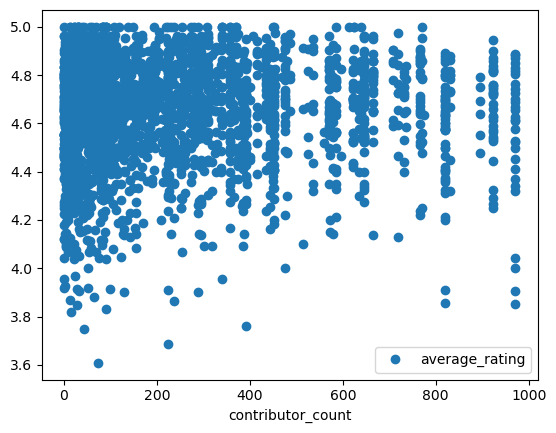

In [53]:
average_recipe_ratings_with_contributors[average_recipe_ratings_with_contributors['contributor_count'] <= 1000].plot(x='contributor_count', y='average_rating', style='o')

#### Recipe features against rating

In [54]:
interactions_with_recipe_features = interactions.merge(recipes, left_on="recipe_id", right_on="id")

In [55]:
interactions_with_recipe_features

,user_id,recipe_id,date,rating,review,date_year,date_month,name,id,minutes,...,description,ingredients,n_ingredients,nutrition_calories,nutrition_total_fat,nutrition_sugar,nutrition_sodium,nutrition_protein,nutrition_saturated_fat,nutrition_carbohydrates
0,56680,152116,2006-03-07,5,"OK, I made this recipe because I went to make ...",2006,3,deli rotisserie chicken,152116,105,...,i have a george foreman rotisserie and love th...,"['roasting chickens', 'salt', 'black pepper', ...",10,649.1,71.0,5.0,33.0,101.0,66.0,1.0
1,8629,152116,2010-08-22,4,This was the first recipe I tried on my Showti...,2010,8,deli rotisserie chicken,152116,105,...,i have a george foreman rotisserie and love th...,"['roasting chickens', 'salt', 'black pepper', ...",10,649.1,71.0,5.0,33.0,101.0,66.0,1.0
2,69838,152116,2006-01-23,5,Fabulous recipe. Made for a great rotisserie c...,2006,1,deli rotisserie chicken,152116,105,...,i have a george foreman rotisserie and love th...,"['roasting chickens', 'salt', 'black pepper', ...",10,649.1,71.0,5.0,33.0,101.0,66.0,1.0
3,220420,152116,2006-03-11,5,"Not only did I impress my DH, and guests with ...",2006,3,deli rotisserie chicken,152116,105,...,i have a george foreman rotisserie and love th...,"['roasting chickens', 'salt', 'black pepper', ...",10,649.1,71.0,5.0,33.0,101.0,66.0,1.0
4,25792,152116,2006-04-25,5,I wish I had an indoor rotisserie cause I woul...,2006,4,deli rotisserie chicken,152116,105,...,i have a george foreman rotisserie and love th...,"['roasting chickens', 'salt', 'black pepper', ...",10,649.1,71.0,5.0,33.0,101.0,66.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138121,45524,91423,2008-12-07,5,This was great! Kittencal had suggested it to ...,2008,12,easy 5 minute almost cheesecake dessert,91423,40,...,this is a wonderful easy dessert and if you ch...,"['butter', 'graham cracker crumbs', 'sweetened...",6,562.3,36.0,176.0,12.0,15.0,67.0,27.0
138122,4291,91423,2004-07-28,5,This was so easy and very good. Thanks for th...,2004,7,easy 5 minute almost cheesecake dessert,91423,40,...,this is a wonderful easy dessert and if you ch...,"['butter', 'graham cracker crumbs', 'sweetened...",6,562.3,36.0,176.0,12.0,15.0,67.0,27.0
138123,85018,91423,2004-09-17,5,Made this today for dinner for the senior citi...,2004,9,easy 5 minute almost cheesecake dessert,91423,40,...,this is a wonderful easy dessert and if you ch...,"['butter', 'graham cracker crumbs', 'sweetened...",6,562.3,36.0,176.0,12.0,15.0,67.0,27.0
138124,58430,91423,2007-12-29,5,I used premium cherry pie filling and almonds ...,2007,12,easy 5 minute almost cheesecake dessert,91423,40,...,this is a wonderful easy dessert and if you ch...,"['butter', 'graham cracker crumbs', 'sweetened...",6,562.3,36.0,176.0,12.0,15.0,67.0,27.0


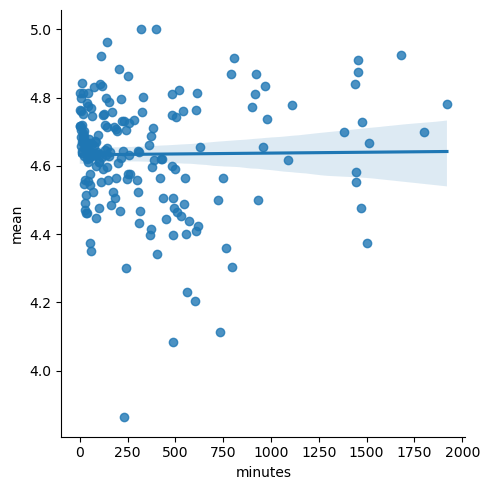

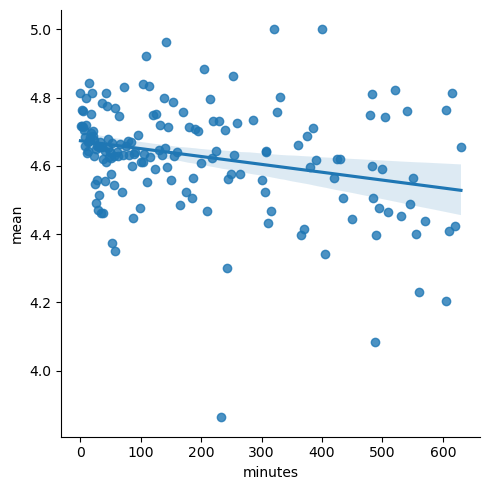

In [56]:
# Minutes
temp_data = interactions_with_recipe_features.groupby("minutes").agg(mean=('rating', 'mean')).reset_index()
sns.lmplot(data=temp_data[temp_data['minutes'] < 2880], x='minutes', y='mean', fit_reg=True)
sns.lmplot(data=temp_data[temp_data['minutes'] < 720], x='minutes', y='mean', fit_reg=True)

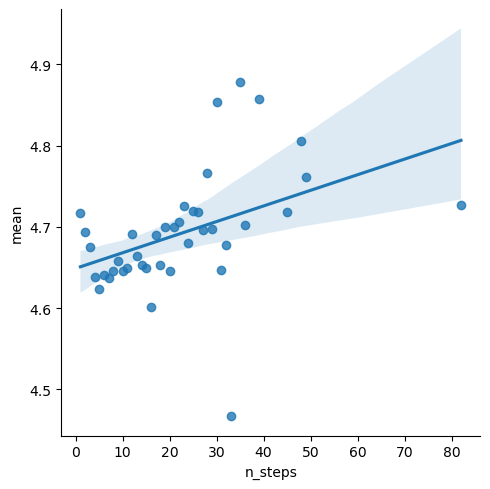

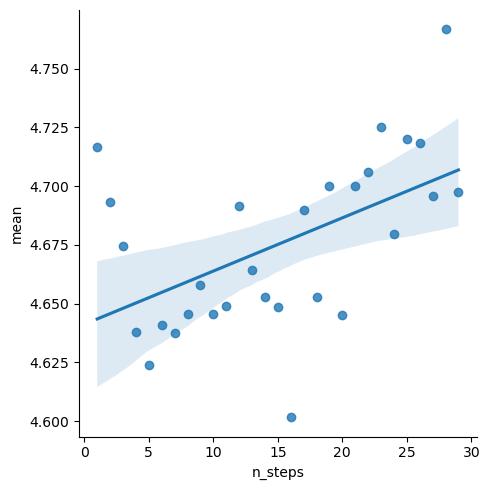

In [57]:
# Steps
temp_data = interactions_with_recipe_features.groupby("n_steps").agg(mean=('rating', 'mean')).reset_index()
sns.lmplot(data=temp_data, x='n_steps', y='mean', fit_reg=True)
sns.lmplot(data=temp_data[temp_data['n_steps'] < 30], x='n_steps', y='mean', fit_reg=True)

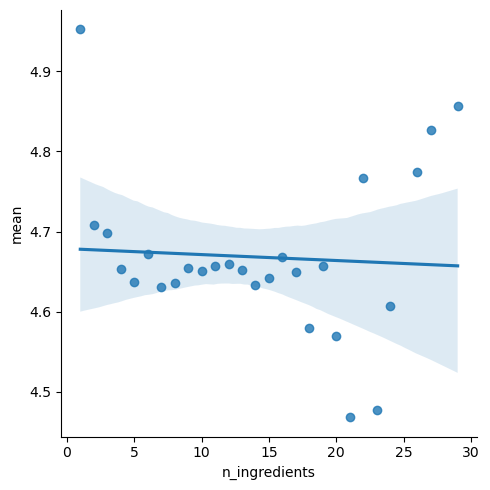

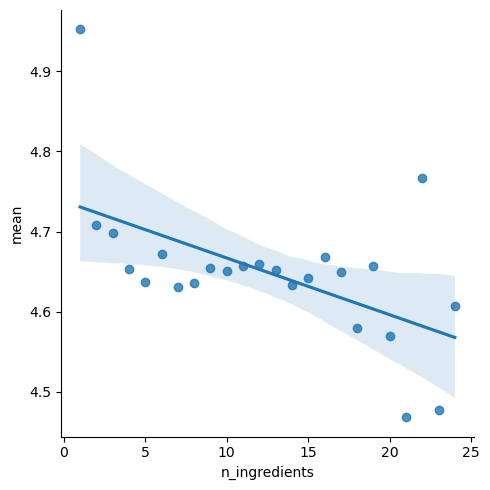

In [58]:
# Steps
temp_data = interactions_with_recipe_features.groupby("n_ingredients").agg(mean=('rating', 'mean')).reset_index()
sns.lmplot(data=temp_data, x='n_ingredients', y='mean', fit_reg=True)
sns.lmplot(data=temp_data[temp_data['n_ingredients'] < 25], x='n_ingredients', y='mean', fit_reg=True)

# Part 2: Identify a predictive task

## What is the predictive task?

Predicting rating

## How to evaluate?


In [59]:
def MSE(predictions, labels):
    return np.mean((predictions - labels)**2)

## Baseline

### Validation pipeline

In [60]:
shuffled_interactions = interactions.sample(frac=1, random_state=RANDOM_SEED)
splits = np.array_split(shuffled_interactions, 10)

# For model that does not require validation (e.g. similarity based model).
interactions_training = pd.concat(splits[:-1])
interactions_test = splits[-1]

# For model that requires a regularization pipeline.
interactions_training_non_validation = pd.concat(splits[:-2])
interactions_training_validation = splits[-2]

### Use average rating of the product

In [61]:
class ProductAveragePredictor:
    def __init__(self, interactions):
        self._interactions = interactions
        self._average_recipe_ratings = interactions.groupby('recipe_id').agg(mean=('rating', 'mean'))

    def predict(self, interactions):
        predictions = interactions['recipe_id'].apply(lambda x: self._average_recipe_ratings.loc[x]['mean'])
        return predictions

    def predict_and_round(self, interactions):
        predictions = interactions['recipe_id'].apply(lambda x: round(self._average_recipe_ratings.loc[x]['mean']))
        return predictions


In [62]:
predictor = ProductAveragePredictor(interactions_training)
predictions = predictor.predict(interactions_test)
rounded_predictions = predictor.predict_and_round(interactions_test)
labels = interactions_test['rating']
mse = MSE(predictions, labels)
print(mse)
rounded_mse = MSE(rounded_predictions, labels)
print(rounded_mse)

0.7750828437798154
0.8933536055603822


### Use average rating given by the user

In [63]:
class UserAveragePredictor:
    def __init__(self, interactions):
        self._interactions = interactions
        self._average_user_ratings = interactions.groupby('user_id').agg(mean=('rating', 'mean'))

    def predict(self, interactions):
        predictions = interactions['user_id'].apply(lambda x: self._average_user_ratings.loc[x]['mean'])
        return predictions

    def predict_and_round(self, interactions):
        predictions = interactions['user_id'].apply(lambda x: round(self._average_user_ratings.loc[x]['mean']))
        return predictions


In [64]:
predictor = UserAveragePredictor(interactions_training)
predictions = predictor.predict(interactions_test)
rounded_predictions = predictor.predict_and_round(interactions_test)
labels = interactions_test['rating']
mse = MSE(predictions, labels)
print(mse)
rounded_mse = MSE(rounded_predictions, labels)
print(rounded_mse)

0.7145178470794291
0.7958297132927888


# Part 3: Describe your model

## Bias-only latent factor model

[TOIMPROVE] Jonathan: I used some code from my assignment 1. However, I did not get a good MSE. Fortunately, I got some good result using Surprise.

There are some possible reasons:
1. Compared to assignment 1 data which is sparse, the filtered dataset that I use is rather dense. I removed all users/recipes which have less than 25 recipes/users (see part 1). There is around 1000 users, 1000 recipes, and 50000 interactions. Thus, latent factor may work better than bias only model. Also, see the next Surprise model.
2. The cross-validation method that I use in Surprise is better than a simple train-validation split.

Maybe we should not spend too much time fine tuning this model? We already have better model using Surprise. Possible improvements:
1. Regualarization pipeline
2. Early stopping

In [65]:
class BiasOnlyLatentFactorPredictor:
    def __init__(self, interactions, regularization):
        self._interactions = interactions
        self._regularization = regularization
        self._size = len(self._interactions)

        self._user_to_recipes = defaultdict(set)
        self._recipe_to_users = defaultdict(set)
        for _, interaction in self._interactions.iterrows():
            self._user_to_recipes[interaction['user_id']].add(interaction['recipe_id'])
            self._recipe_to_users[interaction['recipe_id']].add(interaction['user_id'])

        self._users = list(self._user_to_recipes.keys())
        self._recipes = list(self._recipe_to_users.keys())

        self._alpha = np.mean(interactions['rating'])
        self._user_biases = defaultdict(float)
        self._recipe_biases = defaultdict(float)

    def train(self):
        optimize.fmin_l_bfgs_b(
            self._cost,
            [self._alpha] + [0.0]*(len(self._users)+len(self._recipes)),
            self._derivative,
            args = (self._interactions['rating'], self._regularization),
        )

    def _unpack(self, theta):
        self._alpha = theta[0]
        self._user_biases = dict(zip(self._users, theta[1:len(self._users)+1]))
        self._recipe_biases = dict(zip(self._recipes, theta[1+len(self._recipes):]))

    def _cost(self, theta, labels, lamb):
        self._unpack(theta)
        predictions = [self._predict_interaction(interaction) for _, interaction in self._interactions.iterrows()]
        cost = MSE(predictions, labels)
        print("MSE = " + str(cost))
        for user in self._user_biases:
            cost += lamb*self._user_biases[user]**2
        for recipe in self._recipe_biases:
            cost += lamb*self._recipe_biases[recipe]**2
        return cost

    def _derivative(self, theta, labels, lamb):
        self._unpack(theta)
        d_alpha = 0
        d_user_biases = defaultdict(float)
        d_recipe_biases = defaultdict(float)
        for _, interaction in self._interactions.iterrows():
            user, recipe = interaction['user_id'], interaction['recipe_id']
            pred = self._predict_interaction(interaction)
            diff = pred - interaction['rating']
            d_alpha += 2/self._size*diff
            d_user_biases[user] += 2/self._size*diff
            d_recipe_biases[recipe] += 2/self._size*diff
        for user in self._user_biases:
            d_user_biases[user] += 2*lamb*self._user_biases[user]
        for recipe in self._recipe_biases:
            d_recipe_biases[recipe] += 2*lamb*self._recipe_biases[recipe]
        d_theta = [d_alpha] + [d_user_biases[user] for user in self._users] + [d_recipe_biases[recipe] for recipe in self._recipes]
        return np.array(d_theta)

    def _predict_interaction(self, interaction):
        prediction = self._alpha
        if interaction['user_id'] in self._user_biases:
            prediction += self._user_biases[interaction['user_id']]
        if interaction['recipe_id'] in self._recipe_biases:
            prediction += self._recipe_biases[interaction['recipe_id']]
        return prediction

    def predict(self, interactions):
        return [self._predict_interaction(interaction) for _, interaction in interactions.iterrows()]

In [66]:
predictor = BiasOnlyLatentFactorPredictor(interactions_training, 0.001)

In [67]:
# predictor.train()
# Bad MSE

In [68]:
predictions = predictor.predict(interactions_test)
labels = interactions_test['rating']
mse = MSE(predictions, labels)
print(mse)

0.7789458578070222


## Surprise

In [69]:
def calculate_surprise_mse(model, testset):
    predictions = model.test(testset)
    sse = 0
    for p in predictions:
        sse += (p.r_ui - p.est)**2
    return sse / len(predictions)

In [70]:
# Read the data into a Surprise dataset
surprise_reader = Reader(rating_scale = (0, 5))
surprise_data = Dataset.load_from_df(interactions[['user_id', 'recipe_id', 'rating']], surprise_reader)

surprise_data_test = Dataset.load_from_df(interactions_test[['user_id', 'recipe_id', 'rating']], surprise_reader)
surprise_testset = surprise_data_test.build_full_trainset().build_testset()

In [71]:
model = SVD(random_state=RANDOM_SEED, n_factors=100, reg_all=0.0625)
cross_validate(model, surprise_data, measures=["RMSE"], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8385  0.8292  0.8364  0.8362  0.8218  0.8324  0.0062  
Fit time          1.68    1.54    1.54    1.52    1.51    1.56    0.06    
Test time         0.26    0.40    0.24    0.35    0.22    0.29    0.07    


{'test_rmse': array([0.83849239, 0.82923862, 0.83640311, 0.83622503, 0.82176263]),
 'fit_time': (1.6798698902130127,
  1.5435338020324707,
  1.5405077934265137,
  1.5176758766174316,
  1.5107190608978271),
 'test_time': (0.2606849670410156,
  0.4000389575958252,
  0.2388460636138916,
  0.34645700454711914,
  0.22483110427856445)}

In [72]:
mse = calculate_surprise_mse(model, surprise_testset)
mse

0.5168995851674856

In [73]:
model = SVD(random_state=RANDOM_SEED, n_factors=100, reg_all=0.0625)
model.fit(surprise_data.build_full_trainset())

In [74]:
mse = calculate_surprise_mse(model, surprise_testset)
mse

0.48474347394945544

In [75]:
param_grid = {
    'random_state': [RANDOM_SEED],
    'reg_all': [2**x for x in np.linspace(-20, 0, 21)],
}
print(param_grid)

gs = GridSearchCV(SVD, param_grid, measures=["RMSE"], cv=5, joblib_verbose=1)
gs.fit(surprise_data)

{'random_state': [258258], 'reg_all': [9.5367431640625e-07, 1.9073486328125e-06, 3.814697265625e-06, 7.62939453125e-06, 1.52587890625e-05, 3.0517578125e-05, 6.103515625e-05, 0.0001220703125, 0.000244140625, 0.00048828125, 0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0]}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  3.4min finished


In [76]:
print('Best RMSE:', gs.best_score['rmse'])
print('Best parameters:', gs.best_params['rmse'])
best_model = gs.best_estimator['rmse']
best_model.fit(surprise_data.build_full_trainset())
surprise_data_test = Dataset.load_from_df(interactions_test[['user_id', 'recipe_id', 'rating']], surprise_reader)
surprise_testset = surprise_data_test.build_full_trainset().build_testset()
mse = calculate_surprise_mse(best_model, surprise_testset)
print(mse)


Best RMSE: 0.8282700458228869
Best parameters: {'random_state': 258258, 'reg_all': 0.25}
0.6146166868647417


In [77]:
from gensim.models import Word2Vec
from nltk.stem.porter import *
from sklearn import linear_model
from sklearn.manifold import TSNE
import string

In [78]:
interactions_training

,user_id,recipe_id,date,rating,review,date_year,date_month
19376,314988,136923,2009-03-11,5,Yes! This is what I crave from the mexican res...,2009,3
16777,1706426,90975,2013-07-25,5,"Yum! I love this type of salad, and this did n...",2013,7
48355,341338,80822,2008-10-13,5,My DH loves beef ribs and he gives this recipe...,2008,10
3478,491095,28755,2008-10-14,5,I found this exact recipe in a Mexican Cook bo...,2008,10
53433,222055,47121,2011-11-18,5,Love it and the simplicity of making it! Didn'...,2011,11
...,...,...,...,...,...,...,...
72687,400708,90323,2010-01-26,4,DH and I had this for breakfast today with gri...,2010,1
77236,80980,69753,2015-09-12,5,Very good flavor. Makes great sandwiches. Easy...,2015,9
84486,174991,37413,2006-09-20,5,"Wonderful meal, quick and simple. The only th...",2006,9
46076,18745,31562,2003-12-01,5,MizzNezz all I can say is thankyou for this 5 ...,2003,12


In [79]:
interactions_training.head(1)

,user_id,recipe_id,date,rating,review,date_year,date_month
19376,314988,136923,2009-03-11,5,Yes! This is what I crave from the mexican res...,2009,3


In [80]:
RatingsperRecipe = defaultdict(list)

for index, row in interactions_with_recipe_features.iterrows():
    if row["recipe_id"] in RatingsperRecipe:
        RatingsperRecipe[row["recipe_id"]].append(row["rating"])
    else:
        RatingsperRecipe[row["recipe_id"]] = [row["rating"]]

In [81]:
import statistics
Stddeviationperrecipe = {}
for index in RatingsperRecipe:
    Stddeviationperrecipe[index] = statistics.stdev(RatingsperRecipe[index]) 


In [82]:
list2 = []
for key, val in list(Stddeviationperrecipe.items()):
    if val == 0:
        list2.append(key)

filtered_df = interactions_with_recipe_features[interactions_with_recipe_features['recipe_id'].isin(list2)]
len(filtered_df["name"].unique())

66

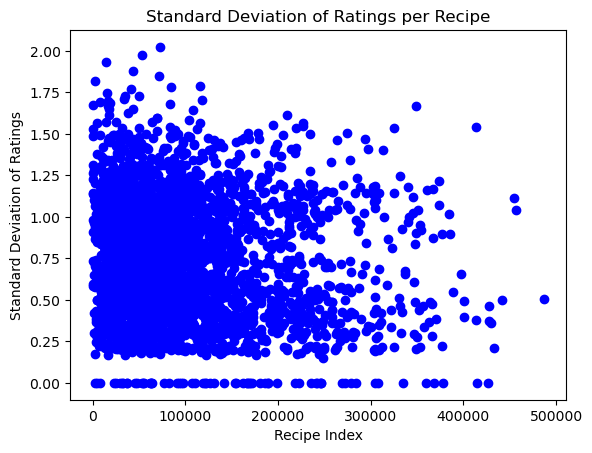

In [83]:
import matplotlib.pyplot as plt
plt.scatter(list(Stddeviationperrecipe.keys()), list(Stddeviationperrecipe.values()), color='blue')
plt.xlabel('Recipe Index')
plt.ylabel('Standard Deviation of Ratings')
plt.title('Standard Deviation of Ratings per Recipe')
plt.show()

In [109]:
X = [feature(row) for row in train_data]

In [110]:
clf = linear_model.Ridge(1.0, fit_intercept=False) # MSE + 1.0 l2
clf.fit(X, train_labels)

Ridge(fit_intercept=False)

In [111]:
Xtest = [feature(row) for row in test_data]

In [112]:
predictions = clf.predict(Xtest)

In [113]:
mse = sum((test_labels - predictions)**2)/len(test_labels)
mse

0.741975528507065

In [114]:
reviewsPerUser = defaultdict(list)
for index, row in interactions_training.iterrows():
    reviewsPerUser[row['user_id']].append((row['recipe_id']))


In [115]:
reviewLists = []
for u in reviewsPerUser:
    rl = list(reviewsPerUser[u])
    rl.sort()
    reviewLists.append([x for x in rl])

In [116]:
model10 = Word2Vec(reviewLists,min_count=5, window=3, sg=1)

In [117]:
ratingMean = interactions_training["rating"].mean()

In [118]:
from collections import defaultdict
itemAverages = defaultdict(list)
reviewsPerUser = defaultdict(list)
    
for index, row in interactions_training.iterrows():
    i = row['recipe_id']
    u = row['user_id']
    itemAverages[i].append(row['rating'])
    reviewsPerUser[u].append(row)
    
for i in itemAverages:
    itemAverages[i] = sum(itemAverages[i]) / len(itemAverages[i])

In [119]:
def predictRating(user,item):
    ratings = []
    similarities = []
    if not str(item) in model10.wv:
        return ratingMean
    for d in reviewsPerUser[user]:
        i2 = d['recipe_id']
        if i2 == item: continue
        ratings.append(d['rating'] - itemAverages[i2])
        if str(i2) in model10.wv:
            similarities.append(model10.wv.distance(str(item), str(i2)))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        return ratingMean

In [120]:
predictions = [predictRating(row['user_id'],row['recipe_id']) for index, row in interactions_test.iterrows()]

In [121]:
labels = [row['rating'] for index, row in interactions_test.iterrows()]

In [122]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [123]:
MSE(predictions, labels)

0.7789458578068885

In [124]:
interactions_with_recipe_features.columns

Index(['user_id', 'recipe_id', 'date', 'rating', 'review', 'date_year',
       'date_month', 'name', 'id', 'minutes', 'contributor_id', 'submitted',
       'tags', 'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients', 'nutrition_calories', 'nutrition_total_fat',
       'nutrition_sugar', 'nutrition_sodium', 'nutrition_protein',
       'nutrition_saturated_fat', 'nutrition_carbohydrates', 'text_features'],
      dtype='object')

In [125]:
interactions_with_recipe_features['text_features'] = interactions_with_recipe_features['name'] + ' ' + interactions_with_recipe_features['description']

In [126]:
interactions_with_recipe_features['text_features'].fillna('', inplace=True)

In [127]:
recipes_per_user = {}
user_per_recipe = {}
average_rating_per_user = {}
average_rating_per_item = {}

In [128]:
dfr = interactions_with_recipe_features[:124314]

In [129]:
for i,d in interactions_with_recipe_features.iterrows():
    if d["user_id"] in recipes_per_user:
        recipes_per_user[d["user_id"]].append((d["recipe_id"],d["rating"],d["text_features"]))
    else:
        recipes_per_user[d["user_id"]] = [(d["recipe_id"],d["rating"],d["text_features"])]
    if d["recipe_id"] in user_per_recipe:
        user_per_recipe[d["recipe_id"]].append((d["user_id"],d["rating"],d["text_features"]))
    else:
        user_per_recipe[d["recipe_id"]] = [((d["user_id"],d["rating"],d["text_features"]))]

In [130]:
for i in recipes_per_user:
    sumr = 0
    for j in recipes_per_user[i]:
        sumr += j[1]
    average_rating_per_user[i] = sumr

for i in user_per_recipe:
    sumr = 0
    for j in user_per_recipe[i]:
        sumr += j[1]
    average_rating_per_item[i] = sumr

In [131]:
ratingMean = interactions_with_recipe_features["rating"].mean()

In [132]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for i,d in dfr.iterrows():
    r = ''.join([c for c in d["text_features"].lower() if not c in punctuation])
    for w in r.split():
        wordCount[w] += 1

In [133]:
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [134]:
words = [x[1] for x in counts]

In [102]:
words = [x[1] for x in counts[:1000]]

In [99]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [100]:
def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in str(datum).lower() if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) 
    return feat

In [135]:
import math
def tfidf(text):
    tf = defaultdict(int)
    r = ''.join([c for c in text.lower() if not c in punctuation])
    for w in r.split():
        tf[w] = 1
    # tfidf = dict(zip(words,[tf[w] * math.log2(len(dfr) / wordCount[w]) for w in words]))
    tfidfQuery = [tf[w] * math.log2(len(dfr) / wordCount[w]) for w in words]
    return tfidfQuery

In [136]:
def Cosine(x1,x2):
    numer = 0
    norm1 = 0
    norm2 = 0
    for a1,a2 in zip(x1,x2):
        numer += a1*a2
        norm1 += a1**2
        norm2 += a2**2
    if norm1*norm2:
        return numer / math.sqrt(norm1*norm2)
    return 0

In [137]:
def predictRating(user,recipe,text):
    ratings = []
    similarities = []
    tfidfQuery = tfidf(text)
    for d in recipes_per_user[user]:
        i2 = d[0]
        if i2 == recipe: continue
        ratings.append(d[1] - average_rating_per_item[i2])
        tfidfRecipe = tfidf(d[2])
        similarities.append(Cosine(tfidfQuery,tfidfRecipe))
    if (sum(similarities) > 0) and recipe in average_rating_per_item:
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return average_rating_per_item[recipe] + sum(weightedRatings) / sum(similarities)
    else:
        return ratingMean

In [139]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

tfidf_train = tfidf_vectorizer.fit_transform(train_data)
tfidf_test = tfidf_vectorizer.transform(test_data)


In [140]:
from sklearn.ensemble import RandomForestRegressor
model = linear_model.Ridge()
model.fit(tfidf_train, train_labels)

Ridge()

In [141]:
predictions = model.predict(tfidf_test)

In [142]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [143]:
def MAE(predictions, labels):
    differences = [abs(x-y) for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [144]:
MSE(predictions, test_labels)


0.7388637577158093

In [145]:
df2 = interactions_with_recipe_features[["n_ingredients","n_steps","nutrition_carbohydrates"]]

In [104]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(df2, interactions_with_recipe_features['rating'], test_size=0.1, random_state=42)

In [105]:
model = linear_model.LinearRegression()
model.fit(train_data, train_labels)
model.coef_

array([-0.00237499,  0.00199465,  0.00019607])

In [106]:
predictions = model.predict(test_data)

In [146]:
MAE(predictions, test_labels)

0.5196774425863255

In [108]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(interactions_with_recipe_features['text_features'], interactions_with_recipe_features['rating'], test_size=0.1, random_state=42)

In [147]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

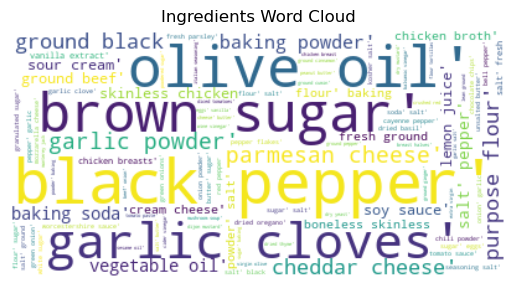

In [165]:
text =''
for i in interactions_with_recipe_features["ingredients"]:
    list1 = i.split(',')
    for j in list1:
        text+=j
text.replace('"',' ')
text.replace("'",' ')
text.replace('[',' ')
text.replace(']',' ')
wordcloud = WordCloud(max_font_size=50,background_color="white").generate(text)
plt.figure()
plt.title("Ingredients Word Cloud")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

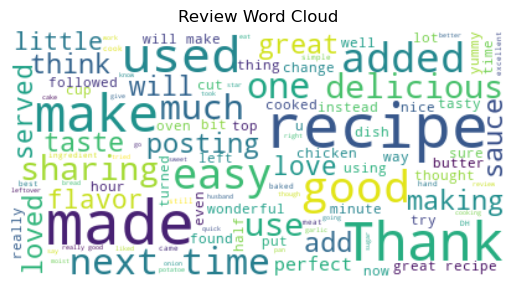

In [171]:
text =''
for i in interactions_with_recipe_features["review"]:
    for j in str(i):
        text+=j
text.replace('"',' ')
text.replace("'",' ')
text.replace('[',' ')
text.replace(']',' ')
wordcloud = WordCloud(max_font_size=50,background_color="white").generate(text)
plt.figure()
plt.title("Review Word Cloud")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()